In [9]:
import pykoop
from sklearn.preprocessing import MaxAbsScaler, StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import seaborn as sns


# 解析解

In [6]:

import numpy as np

def calculate_svd_analytical(lam, mu):
    """
    根据数学推导公式计算 SVD (解析解)
    """
    print(f"--- 解析解计算 (lambda={lam}, mu={mu}) ---")
    
    # 辅助变量 R
    # R = sqrt(lambda^4 + 4*mu^4)
    R = np.sqrt(lam**4 + 4 * mu**4)
    
    # --- 1. 计算奇异值 (Singular Values) ---
    # x2, x3 是 A^TA 的特征值
    x2 = lam**2 + 2*mu**2 + R
    x3 = lam**2 + 2*mu**2 - R
    
    # sigma 是特征值的平方根
    sigma1 = abs(mu)
    sigma2 = np.sqrt(x2)
    # 注意：由于浮点数精度，x3可能极小变成负数，取abs防止报错
    sigma3 = np.sqrt(abs(x3)) 
    
    # 将奇异值排序 (从大到小)，方便与标准库对比
    # 这里我们手动构建一个列表来排序，同时记录原始索引以便重排 U 和 V
    # 原始顺序: index 0 -> sigma1, index 1 -> sigma2, index 2 -> sigma3
    singular_values_list = [
        (sigma1, 0), 
        (sigma2, 1), 
        (sigma3, 2)
    ]
    # 排序
    singular_values_list.sort(key=lambda x: x[0], reverse=True)
    
    sorted_sigmas = [x[0] for x in singular_values_list]
    sorted_indices = [x[1] for x in singular_values_list]
    
    print(f"奇异值 (Sigma): {np.round(sorted_sigmas, 5)}")

    # --- 2. 计算右奇异向量矩阵 V ---
    # v1 (对应 sigma1)
    v1 = np.array([1, 0, 0])
    
    # v2 (对应 sigma2 / x2)
    # 公式: [0, lambda^2, lambda^2 - x2]
    v2_raw = np.array([0, lam**2, lam**2 - x2])
    # 归一化
    if np.linalg.norm(v2_raw) > 1e-10:
        v2 = v2_raw / np.linalg.norm(v2_raw)
    else:
        v2 = np.array([0, 1, 0]) # 处理退化情况
        
    # v3 (对应 sigma3 / x3)
    # 公式: [0, lambda^2, lambda^2 - x3]
    v3_raw = np.array([0, lam**2, lam**2 - x3])
    # 归一化
    if np.linalg.norm(v3_raw) > 1e-10:
        v3 = v3_raw / np.linalg.norm(v3_raw)
    else:
        v3 = np.array([0, 0, 1]) # 处理退化情况

    # 组合 V (按原始顺序)
    V_original = np.column_stack((v1, v2, v3))
    
    # --- 3. 计算左奇异向量矩阵 U ---
    # u1 (对应 sigma1)
    u1 = np.array([1, 0, 0])
    
    # u2 (对应 sigma2 / x2)
    # 公式: [0, 2*mu*lambda, 2*lambda^2 - x2]
    u2_raw = np.array([0, 2*mu*lam, 2*lam**2 - x2])
    # 归一化
    if np.linalg.norm(u2_raw) > 1e-10:
        u2 = u2_raw / np.linalg.norm(u2_raw)
    else:
        u2 = np.array([0, 1, 0])
        
    # u3 (对应 sigma3 / x3)
    # 公式: [0, 2*mu*lambda, 2*lambda^2 - x3]
    u3_raw = np.array([0, 2*mu*lam, 2*lam**2 - x3])
    # 归一化
    if np.linalg.norm(u3_raw) > 1e-10:
        u3 = u3_raw / np.linalg.norm(u3_raw)
    else:
        u3 = np.array([0, 0, 1])

    # 组合 U (按原始顺序)
    U_original = np.column_stack((u1, u2, u3))
    
    # --- 4. 根据奇异值大小重排 U 和 V ---
    # 我们之前记录了 sorted_indices
    U_sorted = U_original[:, sorted_indices]
    V_sorted = V_original[:, sorted_indices]
    
    # 修正符号 (SVD 的向量方向是不确定的，为了与 numpy 对齐，我们可能需要翻转符号)
    # 这是一个为了展示美观的处理，不影响数学正确性
    # 我们通常希望第一非零分量为正
    for i in range(3):
        first_nonzero_u = next((x for x in U_sorted[:, i] if abs(x) > 1e-10), 0)
        if first_nonzero_u < 0:
            U_sorted[:, i] *= -1
            V_sorted[:, i] *= -1 # 必须同时翻转 V 对应的列以保持 A = U Sigma V^T
            
    print("\n左奇异向量矩阵 U (每列为一个向量):")
    print(np.round(U_sorted, 5))
    print("\n右奇异向量矩阵 V (每列为一个向量):")
    print(np.round(V_sorted, 5))
    
    return U_sorted, sorted_sigmas, V_sorted

def verify_with_numpy(lam, mu):
    """
    使用 Numpy 标准库进行验证
    """
    print(f"\n--- Numpy 数值验证 (Check) ---")
    A = np.array([
        [mu, 0, 0],
        [0, lam, -lam],
        [0, 0, 2*mu]
    ])
    
    U_np, S_np, Vt_np = np.linalg.svd(A)
    V_np = Vt_np.T # numpy 返回的是 V^T，我们要 V
    
    print(f"奇异值 (Sigma): {np.round(S_np, 5)}")
    print("\n左奇异向量矩阵 U:")
    print(np.round(U_np, 5))
    print("\n右奇异向量矩阵 V:")
    print(np.round(V_np, 5))

verify_with_numpy(0.6, 0.6)



--- Numpy 数值验证 (Check) ---
奇异值 (Sigma): [1.37295 0.6     0.52442]

左奇异向量矩阵 U:
[[ 0.       1.      -0.     ]
 [-0.52573  0.      -0.85065]
 [ 0.85065  0.      -0.52573]]

右奇异向量矩阵 V:
[[ 0.       1.      -0.     ]
 [-0.22975  0.      -0.97325]
 [ 0.97325  0.      -0.22975]]



--- Numpy 数值验证 (Check) ---


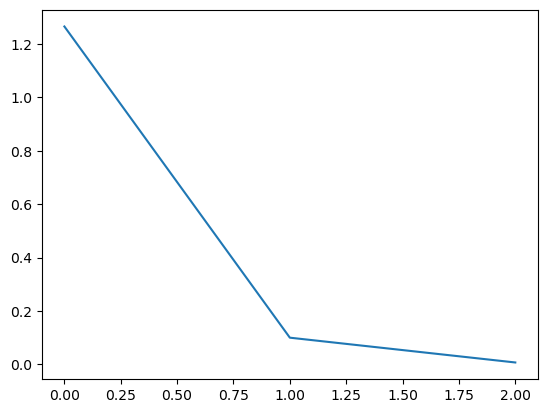

奇异值 (Sigma): [1.26576 0.1     0.00711]

左奇异向量矩阵 U:
[[ 0.       1.       0.     ]
 [ 0.99998  0.       0.00556]
 [-0.00556  0.       0.99998]]

右奇异向量矩阵 V:
[[ 0.       1.       0.     ]
 [ 0.71102  0.       0.70317]
 [-0.70317  0.       0.71102]]


In [25]:
def verify_with_numpy(lam, mu):
    """
    使用 Numpy 标准库进行验证
    """
    print(f"\n--- Numpy 数值验证 (Check) ---")
    A = np.array([
        [lam, 0, 0],
        [0, mu, lam**2-mu],
        [0, 0, lam**2]
    ])
    
    U_np, S_np, Vt_np = np.linalg.svd(A)
    V_np = Vt_np.T # numpy 返回的是 V^T，我们要 V

    plt.figure()
    plt.plot(S_np)
    plt.show()

    print(f"奇异值 (Sigma): {np.round(S_np, 5)}")
    print("\n左奇异向量矩阵 U:")
    print(np.round(U_np, 5))
    print("\n右奇异向量矩阵 V:")
    print(np.round(V_np, 5))

verify_with_numpy(0.1, 0.9)

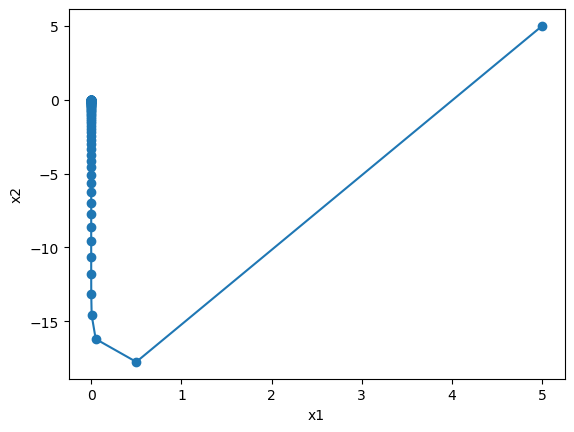

In [28]:
def step(x, y, lam, mu):
    x_next = lam * x
    y_next = mu * y + (lam**2 - mu) * x**2
    return x_next, y_next

def plot_serie(x0, y0, lam=0.01, mu=0.9, steps=100):
    data = np.zeros([steps+1, 2])
    data[0,:] = np.array([x0, y0])
    for s in range(steps):
        x_next, y_next = step(x0, y0, lam, mu)
        data[s+1,:] = np.array([x_next, y_next])
        x0 = x_next
        y0 = y_next
    plt.figure()
    plt.plot(data[:,0], data[:,1], marker = 'o', linestyle = '-')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.show()

plot_serie(x0=5, y0=5, lam=0.1, mu=0.9, steps=100)


--- Numpy 数值验证 (Check) ---


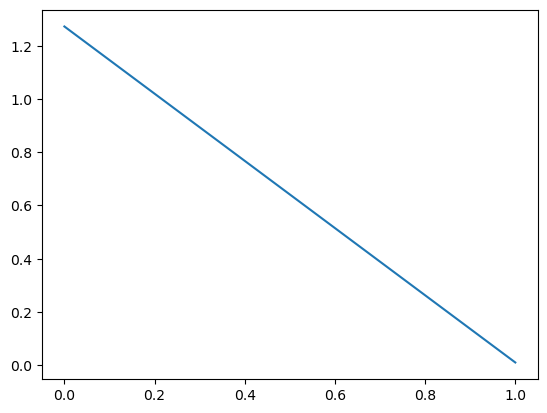

奇异值 (Sigma): [1.27272 0.01   ]

左奇异向量矩阵 U:
[[0. 1.]
 [1. 0.]]

右奇异向量矩阵 V:
[[ 0.       1.       0.     ]
 [ 0.70715  0.       0.70707]
 [-0.70707  0.       0.70715]]


In [16]:
def verify_with_numpy(lam, mu):
    """
    使用 Numpy 标准库进行验证
    """
    print(f"\n--- Numpy 数值验证 (Check) ---")
    A = np.array([
        [lam, 0, 0],
        [0, mu, lam**2-mu]
    ])
    
    U_np, S_np, Vt_np = np.linalg.svd(A)
    V_np = Vt_np.T # numpy 返回的是 V^T，我们要 V

    plt.figure()
    plt.plot(S_np)
    plt.show()

    print(f"奇异值 (Sigma): {np.round(S_np, 5)}")
    print("\n左奇异向量矩阵 U:")
    print(np.round(U_np, 5))
    print("\n右奇异向量矩阵 V:")
    print(np.round(V_np, 5))

verify_with_numpy(0.01, 0.9)

In [18]:

def sir_model_normalized(y, t, beta, gamma):
    """
    归一化SIR模型的微分方程。
    y: 一个包含s, i, r比例的列表或数组
    t: 时间点
    beta: 传染率
    gamma: 康复率
    """
    s, i, r = y
    ds_dt = -beta * s * i
    di_dt = beta * s * i - gamma * i
    dr_dt = gamma * i
    return [ds_dt, di_dt, dr_dt]

# 2. 模型参数和初始条件（保持不变）
initial_infected_ratio = 0.5
initial_recovered_ratio = 0.0
initial_susceptible_ratio = 1.0 - initial_infected_ratio - initial_recovered_ratio

beta = 0.3
gamma = 0.05

y0 = [initial_susceptible_ratio, initial_infected_ratio, initial_recovered_ratio]
total_days = 50
t = np.linspace(0, total_days, total_days*100)
solution = odeint(sir_model_normalized, y0, t, args=(beta, gamma))

s_col = solution[:, 0, np.newaxis]
i_col = solution[:, 1, np.newaxis]
data_noiseless = np.hstack([s_col, i_col, s_col, i_col])

noise_mean = 0.0  # 高斯噪声的均值
noise_std = 0.01 # 高斯噪声的标准差（这是控制“微小”的关键）

noise = noise_mean + np.random.randn(*data_noiseless.shape) * noise_std

data_noisy = data_noiseless + noise

data = data_noisy

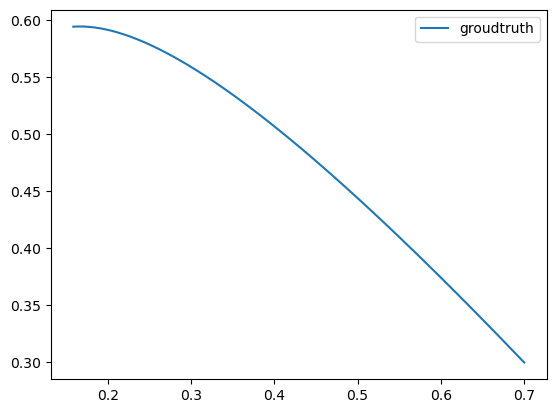

In [117]:
initial_infected_ratio_test = 0.3
initial_recovered_ratio_test = 0.0
initial_susceptible_ratio_test = 1.0 - initial_infected_ratio_test - initial_recovered_ratio_test
y00 = [initial_susceptible_ratio_test, initial_infected_ratio_test, initial_recovered_ratio_test]
total_days = 10
t = np.linspace(0, total_days, 1000)
y0_test = np.array([[initial_susceptible_ratio_test, initial_infected_ratio_test, initial_susceptible_ratio_test, initial_infected_ratio_test]])
solution_test = odeint(sir_model_normalized, y00, t, args=(beta, gamma))

plt.figure()
plt.plot(solution_test[:,0],solution_test[:,1],label='groudtruth')
plt.legend()
plt.show()

In [19]:
#eg = pykoop.example_data_msd()
# kp = pykoop.KoopmanPipeline(
#     lifting_functions=[
#         ('ma', pykoop.SkLearnLiftingFn(MaxAbsScaler())),
#         ('pl', pykoop.PolynomialLiftingFn(order=1)),
#         ('ss', pykoop.SkLearnLiftingFn(StandardScaler())),
#     ],
#     regressor=pykoop.Edmd(alpha=3),
# )
kp = pykoop.KoopmanPipeline(
    lifting_functions=[
        ('pl', pykoop.PolynomialLiftingFn(order=1)),
        ('ss', pykoop.SkLearnLiftingFn(StandardScaler()))
    ],
    regressor=pykoop.Edmd(alpha=0),
)
# Fit the pipeline
kp.fit(
    data,
    n_inputs=0
)
mse_error = -kp.score(data)
mse_error

np.float64(0.01340481830090439)

In [23]:
def compute_eigenfunctions(pipeline, X):
    """
    Compute Koopman eigenfunctions (using left eigenvectors).
    """
    koop_mat = pipeline.regressor_.coef_
    A = koop_mat[:, :koop_mat.shape[0]]
    # 左特征向量，取自 A.T
    eigvals, left_eigvecs = np.linalg.eig(A.T)
    # 提升后的特征
    g_X = pipeline.transform(X)
    # Koopman 特征函数取值
    phi = left_eigvecs @ g_X.T 
    
    return eigvals, phi.T

eigvals, phi = compute_eigenfunctions(kp, data)
eigvals

(4, 4) (5000, 4)


array([0.00681868+0.01852j, 0.00681868-0.01852j, 0.98966461+0.j     ,
       0.99858124+0.j     ])

In [16]:
import numpy as np
import pykoop
from sklearn.metrics import mean_squared_error

def get_lifting_space_mse(kp: pykoop.KoopmanPipeline, X: np.ndarray) -> np.ndarray:
    """
    Calculate the Mean Squared Error (MSE) for each dimension in the lifting function space.
    This function evaluates the quality of the linear fit performed by the regressor.
    """
    # The fitted regressor should exist after calling fit()
    if not hasattr(kp, 'regressor_'):
        raise RuntimeError("KoopmanPipeline not fitted. Call 'fit()' first.")

    # 1. Get the fitted lifting function(s) from the pipeline.
    # FINAL CORRECTED ACCESS PATH: `kp.lifting_functions_`
    # This attribute holds the list of fitted lifting function transformers.
    if not hasattr(kp, 'lifting_functions_') or not kp.lifting_functions_:
        warnings.warn(
            "No lifting functions found in the pipeline. "
            "The lifting space is the same as the state space. "
            "Ensure 'lifting_functions' was set during initialization."
        )
        # If no lifting functions, the "lifted" space is just the original space.
        lifting_transformer = pykoop.IdentityLiftingFn()
        lifting_transformer.fit(X)
    else:
        # Assuming one primary lifting function for simplicity, as is common.
        # It's a list of ('name', transformer) tuples.
        lifting_transformer = kp.lifting_functions_[0][1]

    # 2. Lift the entire dataset into the feature space
    Psi = lifting_transformer.transform(X)

    # 3. Separate into "before" and "after" sets
    Psi_t = Psi[:-1, :]         # Inputs for prediction (t=0 to n-2)
    Psi_t_plus_1 = Psi[1:, :]   # True targets (t=1 to n-1)

    # 4. Get the Koopman operator matrix
    koopman_matrix_T = kp.regressor_.coef_
    
    # 5. Predict in the lifting space
    Psi_pred_t_plus_1 = Psi_t @ koopman_matrix_T

    # 6. Calculate MSE for each dimension of the lifting space
    n_lifting_dims = Psi.shape[1]
    per_lifting_dim_mse = np.zeros(n_lifting_dims)

    for i in range(n_lifting_dims):
        mse = mean_squared_error(Psi_t_plus_1[:, i], Psi_pred_t_plus_1[:, i])
        per_lifting_dim_mse[i] = mse

    return per_lifting_dim_mse


get_lifting_space_mse(kp,data)


array([0.00015142, 0.00015318, 0.00014735, 0.00015012])

In [159]:
import random

# 生成第一个随机整数，范围为1到10（包含1和10）
num1 = random.randint(1, 10)

# 生成第二个随机整数，范围为0到29（小于30）
num2 = random.randint(0, 29)

print("第一个随机数（1-10）：", num1)
print("第二个随机数（小于30）：", num2)


第一个随机数（1-10）： 5
第二个随机数（小于30）： 17


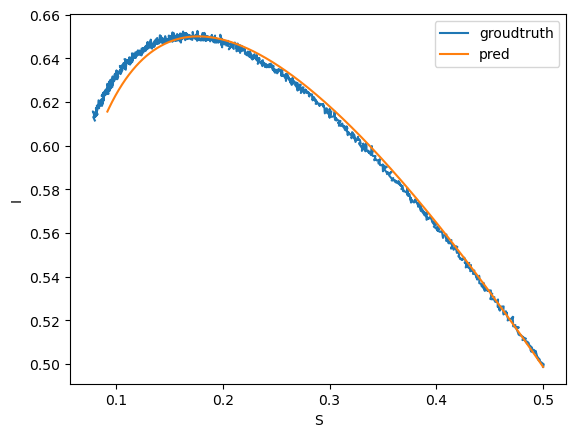

In [157]:
p_steps = 1000
X_test = data[:p_steps,:]
pred = kp.predict_trajectory(X_test,None)
plt.figure()
plt.plot(X_test[:,0],X_test[:,1],label='groudtruth')
plt.plot(pred[:,0],pred[:,1],label='pred')
plt.xlabel('S')
plt.ylabel('I')
plt.legend()
plt.show()


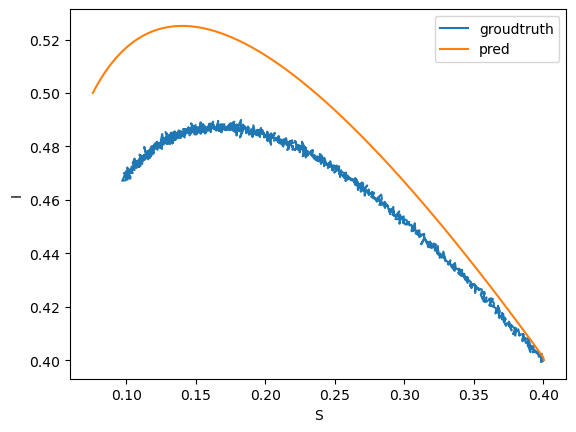

In [158]:
initial_infected_ratio = 0.4
initial_recovered_ratio = 0.2
initial_susceptible_ratio = 1.0 - initial_infected_ratio - initial_recovered_ratio

beta = 0.3
gamma = 0.05

y0 = [initial_susceptible_ratio, initial_infected_ratio, initial_recovered_ratio]
total_days = 200
t = np.linspace(0, total_days, 20000)
solution = odeint(sir_model_normalized, y0, t, args=(beta, gamma))

s_col = solution[:, 0, np.newaxis]
i_col = solution[:, 1, np.newaxis]
data_noiseless = np.hstack([s_col, i_col, s_col, i_col])

noise_mean = 0.0  # 高斯噪声的均值
noise_std = 0.001 # 高斯噪声的标准差（这是控制“微小”的关键）

noise = noise_mean + np.random.randn(*data_noiseless.shape) * noise_std

data_noisy = data_noiseless + noise

data = data_noisy

p_steps = 1000
X_test = data[:p_steps,:]
pred = kp.predict_trajectory(X_test,None)
plt.figure()
plt.plot(X_test[:,0],X_test[:,1],label='groudtruth')
plt.plot(pred[:,0],pred[:,1],label='pred')
plt.xlabel('S')
plt.ylabel('I')
plt.legend()
plt.show()

(<Figure size 640x480 with 2 Axes>, <Axes: >)

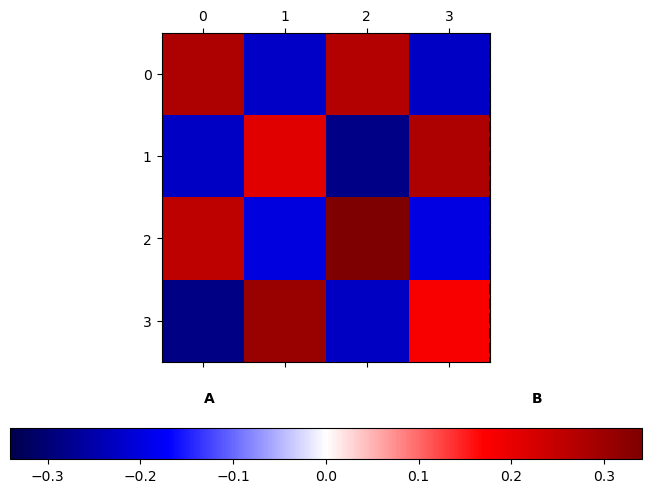

In [123]:
kp.regressor_.plot_koopman_matrix()

(<Figure size 640x480 with 1 Axes>,
 <PolarAxes: xlabel='$\\mathrm{Re}(\\lambda)$', ylabel='$\\mathrm{Im}(\\lambda)$'>)

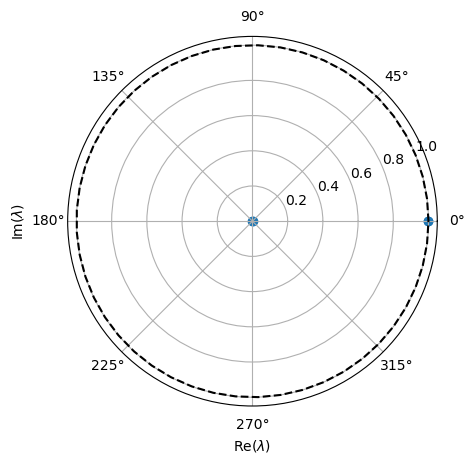

In [114]:
kp.regressor_.plot_eigenvalues()

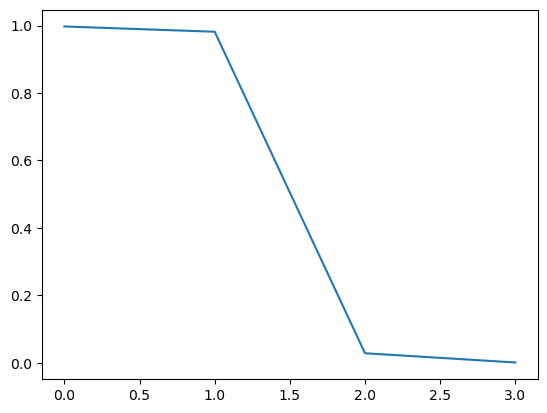

In [152]:
A = kp.regressor_.coef_
U,S,V = np.linalg.svd(A)
plt.figure()
plt.plot(S)
plt.show()

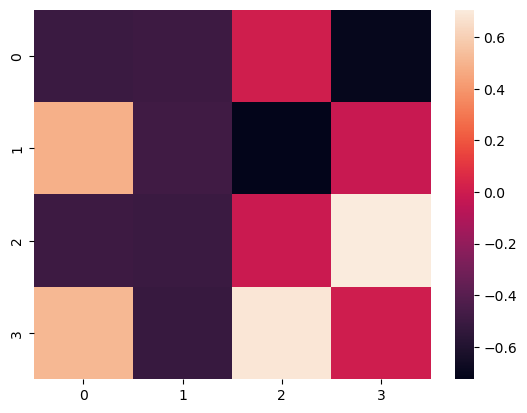

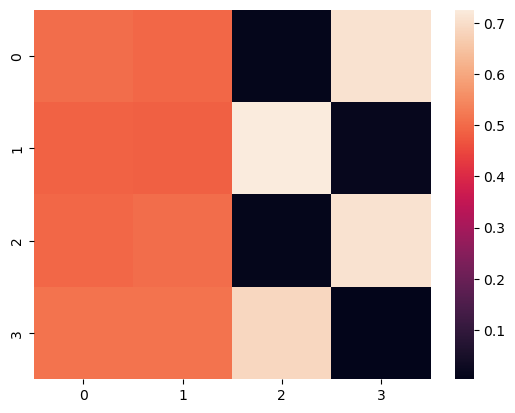

In [153]:
U_abs = np.abs(U)
plt.figure()
sns.heatmap(U)
plt.show()
plt.figure()
sns.heatmap(U_abs)
plt.show()

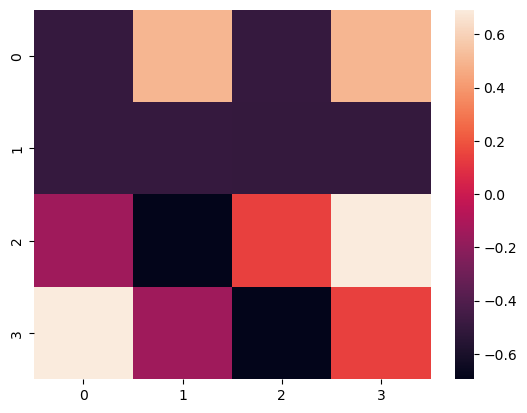

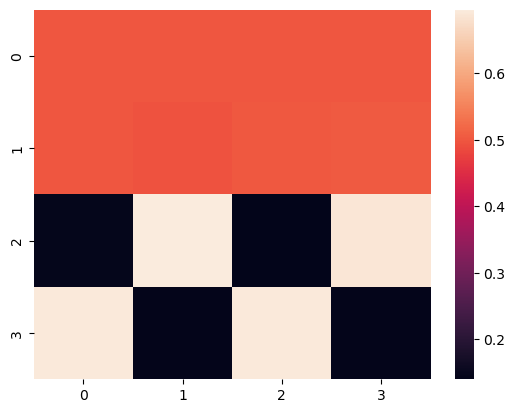

In [154]:
V_abs = np.abs(V)
plt.figure()
sns.heatmap(V)
plt.show()
plt.figure()
sns.heatmap(V_abs)
plt.show()

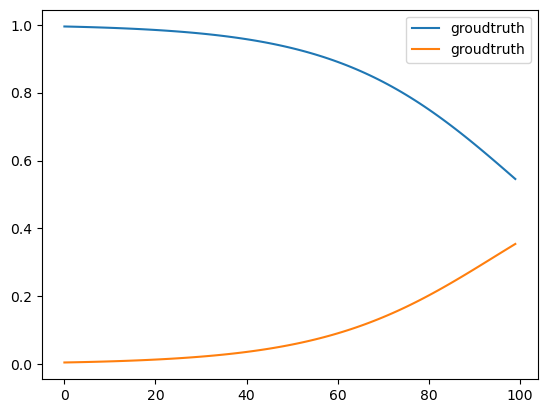

array([[0.995     , 0.005     ],
       [0.99531503, 0.00551855],
       [0.99609112, 0.00605806],
       [0.99757958, 0.00661943],
       [1.00016453, 0.00720366],
       [1.00443571, 0.0078119 ],
       [1.01130489, 0.00844558],
       [1.02219719, 0.00910654],
       [1.03937688, 0.00979728],
       [1.06653035, 0.01052149]])

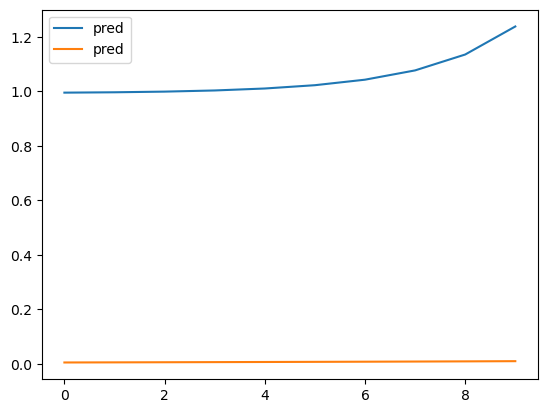

In [44]:
n_steps = 10
pred_traj = np.zeros([n_steps,4])
y0 = y0_test
for i in range(n_steps):
    y0 = kp.predict(y0)
    pred_traj[i,:] = y0
plt.figure()
plt.plot(pred_traj[:,0],label='pred')
plt.plot(pred_traj[:,1],label='pred')
#plt.plot(pred[:,0],label='pred')
plt.legend()
plt.show()

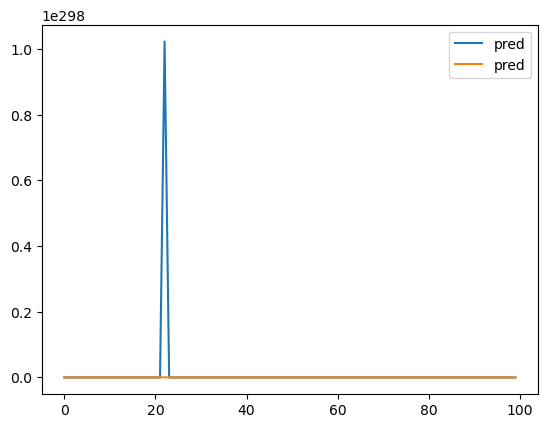

In [43]:
plt.figure()
plt.plot(pred_traj[:,0],label='pred')
plt.plot(pred_traj[:,1],label='pred')
#plt.plot(pred[:,0],label='pred')
plt.legend()
plt.show()

In [27]:
eg = pykoop.example_data_msd()
eg['x0_valid'], eg['u_valid'].shape

(array([[3., 0., 0.]]), (100, 2))